### Pedalcast: Predicting daily bike usage for each station - Cleaning Notebook

#### Data Sources

This project uses two main datasets:

- **BlueBikes Trip Data**  
  Historical trip records from Boston's BlueBikes system, including start/end stations, timestamps, and bike types. The data used in this project spans July 2023 through June 2025.

  📂 Source: [BlueBikes Open Data Portal](https://s3.amazonaws.com/hubway-data/index.html)


- **Weather Data**  
  Daily weather conditions (temperature, precipitation, wind, visibility, etc.) for the Boston area, aligned with each ride day.  
  
  📂 Source: [Visual Crossing Weather](https://www.visualcrossing.com/weather-data)

These datasets are combined to train a model that predicts daily bike demand at the station level.

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from glob import glob

##### Combining Monthly Trip Data

In the cell below, we load and combine all monthly BlueBikes trip data files into a single DataFrame.

Each monthly dataset is stored as a CSV file named in the format:  
`YYYY-MM-bluebikes-tripdata.csv` inside the `data/` directory.

We use `glob` to match all relevant files, then read them into pandas DataFrames.  

In [3]:
csv_files = sorted(glob("data/*-bluebikes-tripdata.csv"))

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"❌ Failed to load {f}: {e}")

if dfs:
    trips = pd.concat(dfs, ignore_index=True)
    print(f"✅ Combined shape: {trips.shape}")
else:
    print("❌ No CSVs loaded. Check filename pattern or folder.")

✅ Combined shape: (8793350, 13)


We keep only the columns needed for daily station-level analysis:  
`started_at`, `start_station_name`, and `start_station_id`.

2033 rows are dropped due to missing start_station_id, and a `date` column is created by extracting the day from the `started_at` timestamp and converting it to a datetime object.

In [4]:
relevant_cols = ['started_at','start_station_name','start_station_id']
trips = trips[relevant_cols]
trips=trips.dropna()
trips['date'] = pd.to_datetime(pd.to_datetime(trips['started_at'],format='mixed').dt.date)
trips

started_at  \
0            2023-07-18 13:48:34   
1            2023-07-19 12:16:30   
2            2023-07-28 17:49:26   
3            2023-07-22 23:14:17   
4            2023-07-21 18:41:22   
...                          ...   
8793345  2025-06-12 20:20:45.355   
8793346  2025-06-25 17:13:30.010   
8793347  2025-06-09 16:03:20.398   
8793348  2025-06-03 09:22:41.353   
8793349  2025-06-21 12:34:17.333   

                                        start_station_name start_station_id  \
0        Roxbury Crossing T Stop - Columbus Ave at Trem...           C32001   
1        Roxbury Crossing T Stop - Columbus Ave at Trem...           C32001   
2        Roxbury Crossing T Stop - Columbus Ave at Trem...           C32001   
3        Roxbury Crossing T Stop - Columbus Ave at Trem...           C32001   
4        Roxbury Crossing T Stop - Columbus Ave at Trem...           C32001   
...                                                    ...              ...   
8793345                       Tremont St at Northampton St           C32056   
8793346         Park Street T Stop - Tremont St at Park St           B32068   
8793347     Innovation Lab - 125 Western Ave at Batten Way           A32011   
8793348                          Centre St at Seaverns Ave           E32008   
8793349                          Centre St at Seaverns Ave           E32008   

              date  
0       2023-07-18  
1       2023-07-19  
2       2023-07-28  
3       2023-07-22  
4       2023-07-21  
...            ...  
8793345 2025-06-12  
8793346 2025-06-25  
8793347 2025-06-09  
8793348 2025-06-03  
8793349 2025-06-21  

[8791317 rows x 4 columns]

We first filter the trip data to include only rides from June 2025.

Then, we extract the list of stations that were active (i.e., had trips) during that month.

Finally, we filter the full dataset to keep only trips from those active stations, ensuring consistency when forecasting or evaluating recent demand.

In [5]:
# Filter to June 2025 only
trips_may = trips[(trips['date'] >= '2025-06-01') & (trips['date'] <= '2025-06-30')]

# Get station IDs active in June 2025
active_stations = trips_may['start_station_id'].unique()
trips_active = trips[trips['start_station_id'].isin(active_stations)]
trips_active.head()

started_at                                 start_station_name  \
0  2023-07-18 13:48:34  Roxbury Crossing T Stop - Columbus Ave at Trem...   
1  2023-07-19 12:16:30  Roxbury Crossing T Stop - Columbus Ave at Trem...   
2  2023-07-28 17:49:26  Roxbury Crossing T Stop - Columbus Ave at Trem...   
3  2023-07-22 23:14:17  Roxbury Crossing T Stop - Columbus Ave at Trem...   
4  2023-07-21 18:41:22  Roxbury Crossing T Stop - Columbus Ave at Trem...   

  start_station_id       date  
0           C32001 2023-07-18  
1           C32001 2023-07-19  
2           C32001 2023-07-28  
3           C32001 2023-07-22  
4           C32001 2023-07-21

In [6]:
daily_counts = (
    trips_active.groupby(['start_station_id', 'start_station_name', 'date'])
                .size()
                .reset_index(name='trip_count')
)
daily_counts.head()

start_station_id start_station_name       date  trip_count
0           A32000           Fan Pier 2023-07-01          30
1           A32000           Fan Pier 2023-07-02          20
2           A32000           Fan Pier 2023-07-03          28
3           A32000           Fan Pier 2023-07-04          35
4           A32000           Fan Pier 2023-07-05          41

In [7]:
weather = pd.read_csv('data/boston_weather.csv')
weather = weather[['datetime','temp','humidity','precip','snow','windspeed','visibility','cloudcover']]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather =weather.rename({'datetime':'date'},axis=1)
weather.head()

date  temp  humidity  precip  snow  windspeed  visibility  cloudcover
0 2023-06-30  21.5      82.3   0.000   0.0       22.0        15.4        48.3
1 2023-07-01  19.3      93.5   0.000   0.0       20.3         4.8        90.6
2 2023-07-02  20.9      89.9   8.278   0.0       28.9         7.6        98.5
3 2023-07-03  20.4      89.4  14.249   0.0       18.0        10.4        89.5
4 2023-07-04  20.1      94.4  12.163   0.0       16.4        12.0        96.0

In [8]:
daily_counts_w = daily_counts.merge(weather,on='date',how='left')
daily_counts_w

start_station_id          start_station_name       date  trip_count  \
0                A32000                    Fan Pier 2023-07-01          30   
1                A32000                    Fan Pier 2023-07-02          20   
2                A32000                    Fan Pier 2023-07-03          28   
3                A32000                    Fan Pier 2023-07-04          35   
4                A32000                    Fan Pier 2023-07-05          41   
...                 ...                         ...        ...         ...   
316072          ZZ32996  Auburn St. at Mystic River 2025-06-26           5   
316073          ZZ32996  Auburn St. at Mystic River 2025-06-27           6   
316074          ZZ32996  Auburn St. at Mystic River 2025-06-28           2   
316075          ZZ32996  Auburn St. at Mystic River 2025-06-29           6   
316076          ZZ32996  Auburn St. at Mystic River 2025-06-30           7   

        temp  humidity  precip  snow  windspeed  visibility  cloudcover  
0       19.3      93.5   0.000   0.0       20.3         4.8        90.6  
1       20.9      89.9   8.278   0.0       28.9         7.6        98.5  
2       20.4      89.4  14.249   0.0       18.0        10.4        89.5  
3       20.1      94.4  12.163   0.0       16.4        12.0        96.0  
4       23.9      78.4   0.000   0.0       17.8        13.3        53.3  
...      ...       ...     ...   ...        ...         ...         ...  
316072  20.5      63.7   0.019   0.0       23.9        16.0        97.6  
316073  18.6      66.1   0.000   0.0       25.6        16.0        76.9  
316074  17.3      84.8   0.782   0.0       18.2         8.8       100.0  
316075  20.1      85.8   0.000   0.0       18.3        11.6        67.8  
316076  23.4      68.2   0.000   0.0       27.1        15.9        43.2  

[316077 rows x 11 columns]

In [9]:
daily_counts_w.to_csv("data/daily_counts_with_weather.csv", index=False)

#### EDA

##### Distribution of Daily Bike Usage (Target Variable)

In [10]:
fig = px.histogram(
    daily_counts_w,
    x="trip_count",
    nbins=50,  # increase bin resolution
    title="Distribution of Daily Trip Counts (Per Station)",
    labels={"trip_count": "Number of Trips"},
    opacity=0.75
)

fig.update_layout(
    xaxis_title="Number of Trips",
    yaxis_title="Frequency",
    bargap=0.05
)

fig.show()

This histogram shows how frequently different levels of daily Bluebikes trip counts occur across all stations in the dataset.
Observations:
- Right-skewed distribution:
  - The majority of trip counts entries have fewer than 50 trips.
  - Most common daily counts are concentrated in the 0–20 trip range.

- Long tail:
  - Some stations occasionally record 100+ trips/day, and a few surpass 400.
  - These are likely high-traffic commuter or central city locations.

##### Top 10 Most Used Stations

In [11]:
daily_counts_w.groupby(['start_station_name','start_station_id'])['trip_count'].sum().sort_values(ascending=False)[:10]

start_station_name                                           start_station_id
MIT at Mass Ave / Amherst St                                 M32006              168000
Central Square at Mass Ave / Essex St                        M32011              129261
Harvard Square at Mass Ave/ Dunster                          M32018              115211
MIT Vassar St                                                M32042               96871
MIT Pacific St at Purrington St                              M32041               93428
Charles Circle - Charles St at Cambridge St                  D32016               88383
Ames St at Main St                                           M32037               85390
Christian Science Plaza - Massachusetts Ave at Westland Ave  B32005               78519
Mass Ave/Lafayette Square                                    M32085               76627
Beacon St at Massachusetts Ave                               B32016               74384
Name: trip_count, dtype: int64

In [12]:
daily_counts_w.columns

Index(['start_station_id', 'start_station_name', 'date', 'trip_count', 'temp',
       'humidity', 'precip', 'snow', 'windspeed', 'visibility', 'cloudcover'],
      dtype='object')

#### Learning Relations between Weather Conditions and Bike Usage(Trip Count)

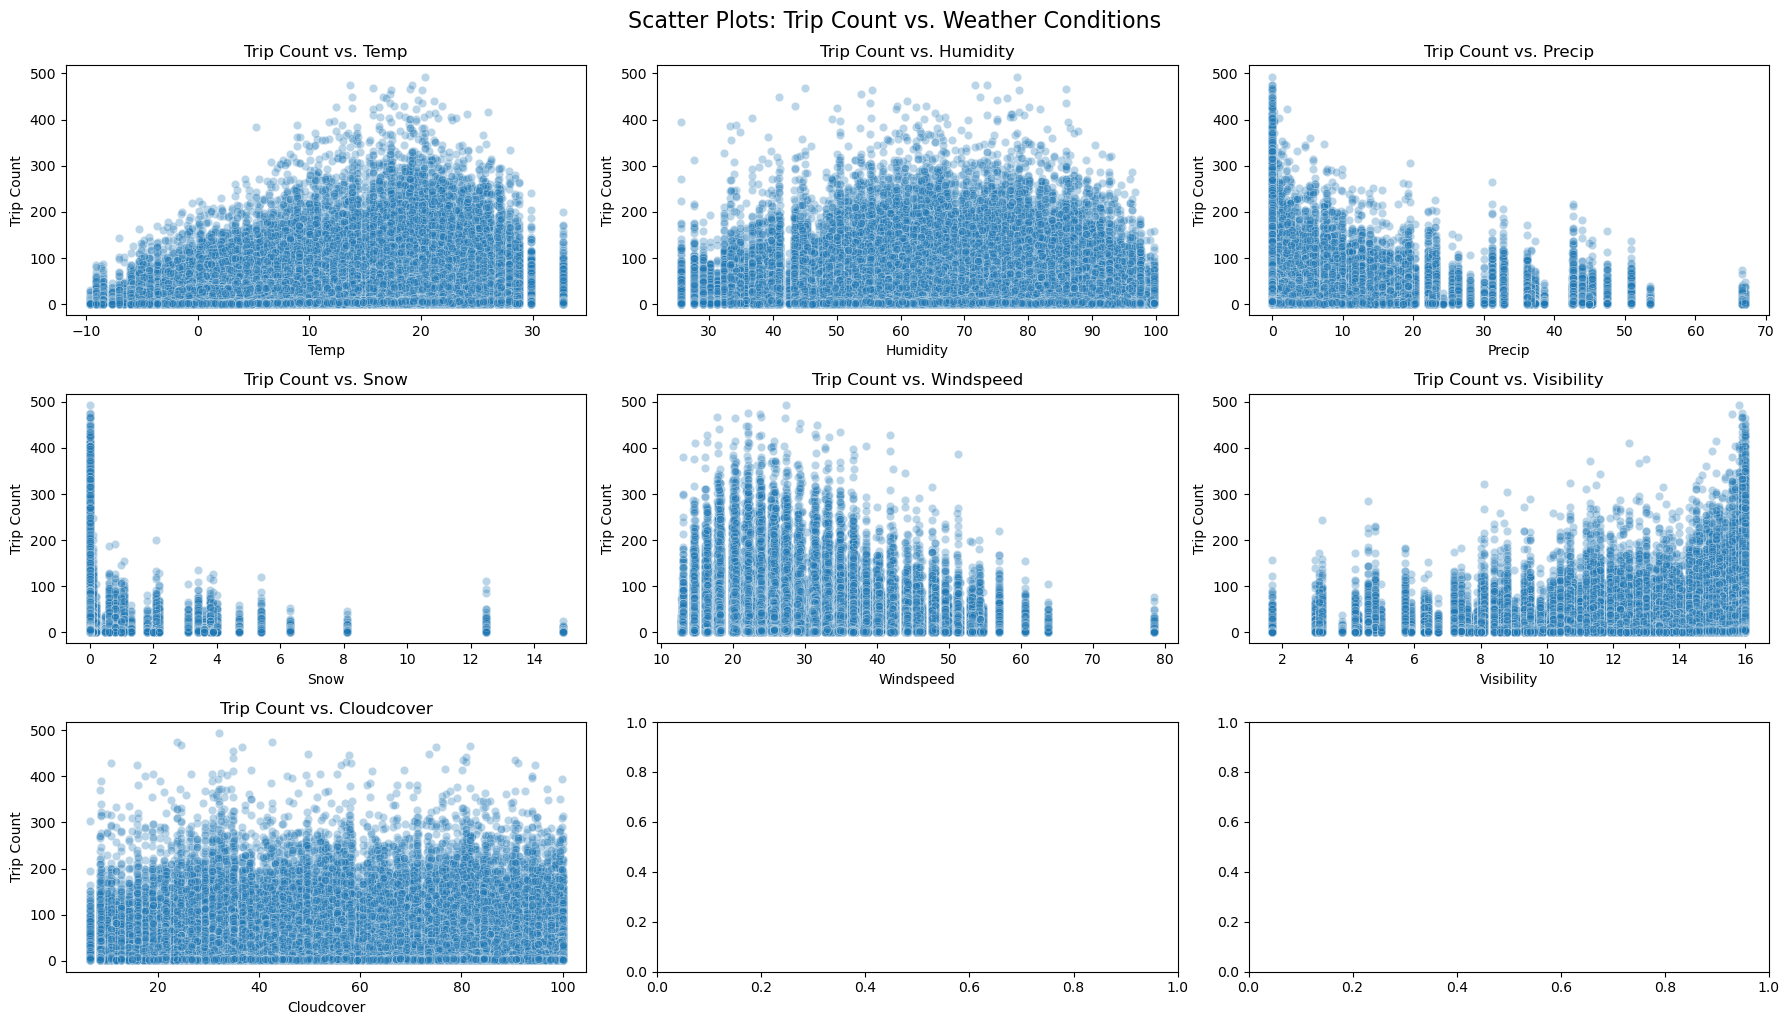

In [13]:

# List of weather features to compare
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility','cloudcover']

# Set up figure
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    ax = axes[i]
    sns.scatterplot(
        data=daily_counts_w,
        x=var,
        y='trip_count',
        alpha=0.3,
        ax=ax
    )
    ax.set_title(f'Trip Count vs. {var.capitalize()}')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Trip Count')
plt.tight_layout()
plt.suptitle('Scatter Plots: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_4485/2143631813.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_4485/2143631813.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_4485/2143631813.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_4485/2143631813.py:15: UserWarning:

set_ticklabels() should only be used with a fixed numb

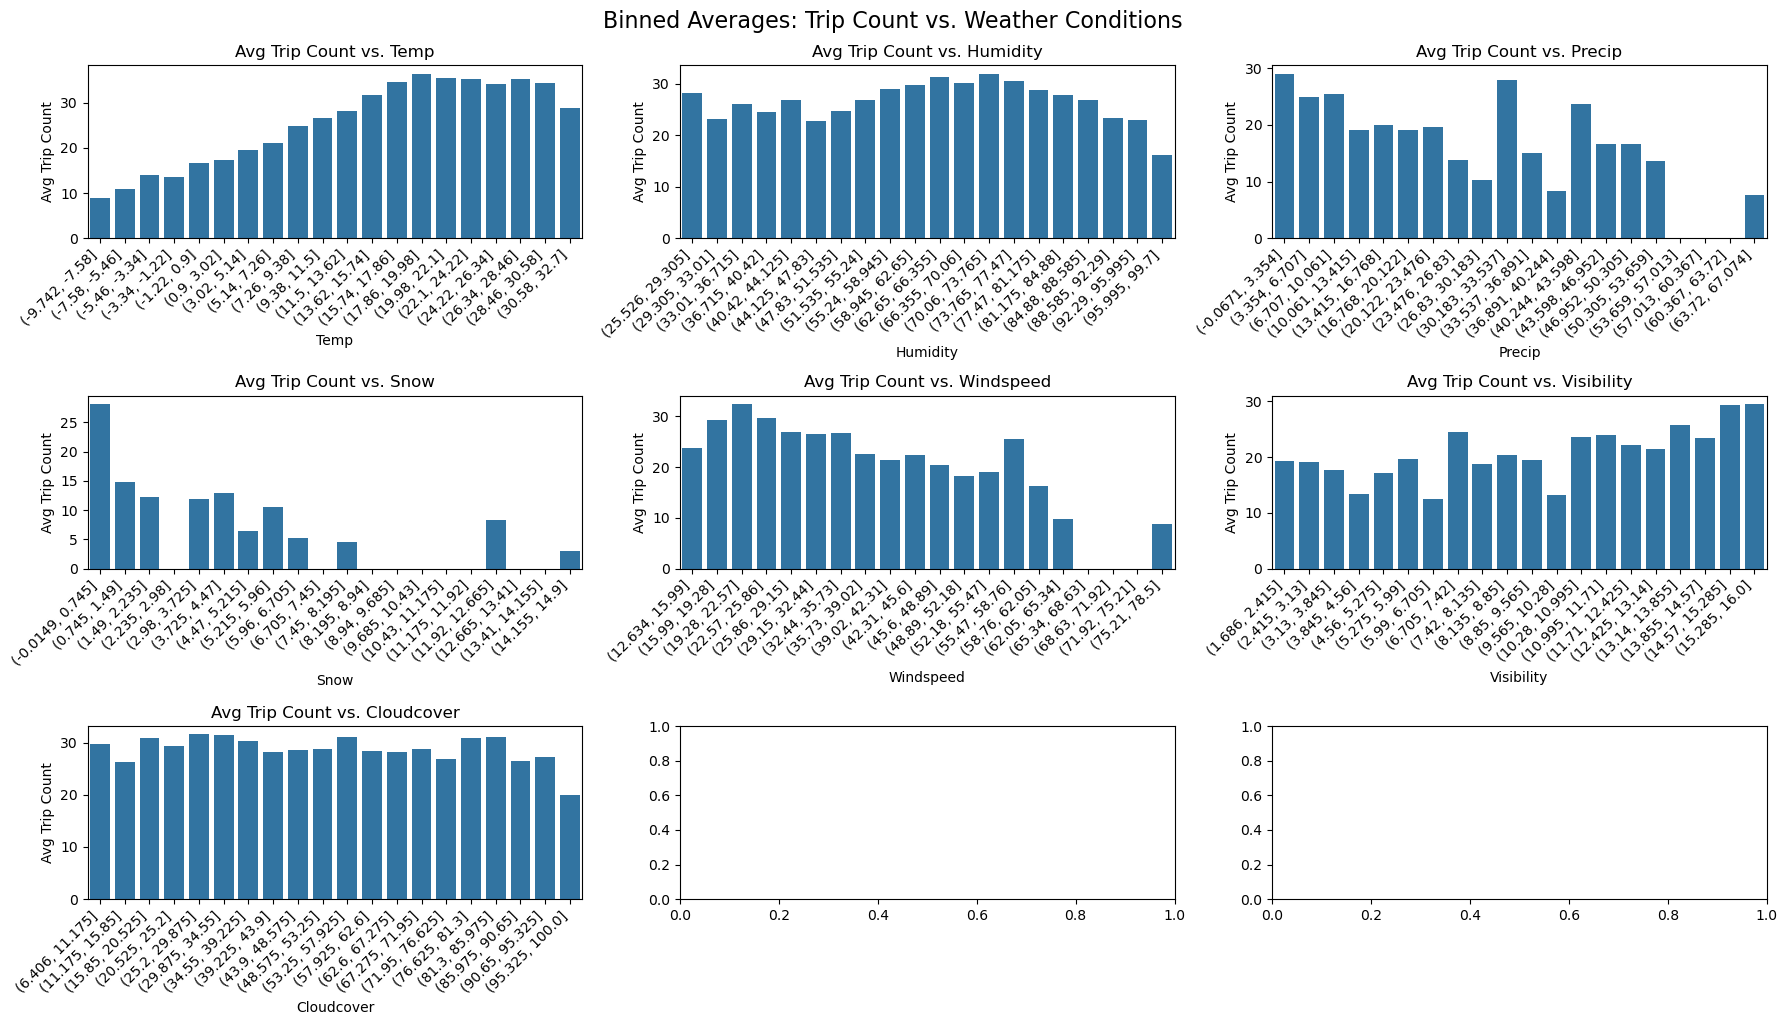

In [14]:
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility','cloudcover']

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()
daily_counts_w2 = daily_counts_w.copy()
for i, var in enumerate(weather_vars):
    # Bin the variable
    daily_counts_w2[f'{var}_bin'] = pd.cut(daily_counts_w2[var], bins=20)
    grouped = daily_counts_w2.groupby(f'{var}_bin')['trip_count'].mean().reset_index()

    # Plot
    ax = axes[i]
    sns.barplot(x=f'{var}_bin', y='trip_count', data=grouped, ax=ax)
    ax.set_title(f'Avg Trip Count vs. {var.capitalize()}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Avg Trip Count')
plt.tight_layout()
plt.suptitle('Binned Averages: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

We examine the relationship between daily trip counts and various weather variables using scatterplots and bar plots of binned averages. Below is a summary of the observed trends:

##### Temperature (`temp`)
- Strong positive trend: As temperature increases from below freezing to ~20°C, trip counts rise steadily.
- Plateaus or dips above ~25–30°C, possibly due to heat discomfort.
- Ideal range for biking appears to be 15–25°C.

##### Humidity (`humidity`)
- Bell-shaped pattern: peak bike usuage at humidity (~60–75%).
- Fewer trips at both very low (<40%) and very high (>90%) levels.

##### Precipitation (`precip`)
- Strong negative correlation: demand drops sharply as rain increases.
- Most trips occur at 0 mm precipitation.
- Negative Relationship

##### Snow (`snow`)
- Very low usage when any measurable snow is present.
- Negative Relationship

##### Windspeed (`windspeed`)
- General negative trend after 23 km/h wind speeds.

##### Visibility (`visibility`)
- Positive correlation: more trips on clear, high-visibility days (12–16 km).
- Low-visibility days (e.g., fog, storm) show less demand.
- Positive Relationship
##### Cloudcover (`cloudcover`)
- relatively flat. However, very high cloudcover decreases trip count.
- Can still improve model with interactions with other weather conditions


#### Bike Usage(Trip Count) over Time

In [15]:
# Group by date to get daily trip totals
daily_total = daily_counts_w.groupby('date')['trip_count'].sum().reset_index()

# Compute 7-day rolling average
daily_total['rolling_7'] = daily_total['trip_count'].rolling(7).mean()

# --- Plot 1: Raw Daily Trip Count ---
fig_daily = px.line(
    daily_total,
    x='date',
    y='trip_count',
    title='Daily Bluebikes Trips Over Time',
    labels={'trip_count': 'Trip Count', 'date': 'Date'}
)
fig_daily.update_layout(template='plotly_white', hovermode='x unified')

# --- Plot 2: 7-Day Rolling Average ---
fig_rolling = px.line(
    daily_total,
    x='date',
    y='rolling_7',
    title='7-Day Rolling Average of Bluebikes Trips',
    labels={'rolling_7': '7-Day Avg Trip Count', 'date': 'Date'}
)
fig_rolling.update_layout(template='plotly_white', hovermode='x unified')

# Show both
fig_daily.show()
fig_rolling.show()

Observations:

- Clear seasonal fluctuations: usage dips sharply in winter months (Dec–Feb) and rises in spring/summer.
- Notable troughs are visible around late December and early January, aligning with the winter holiday season.

Based on these observations, we will create new features later on:
- **`is_us_holiday`**: A binary variable indicating whether a given date is a U.S. federal holiday.

This addition helps the model capture abrupt dips in ridership caused by national holidays, particularly around Christmas, New Year's Day, and other holidays like Independence Day and Thanksgiving  

- **`season`**: A categorical variable derived from the date's month, helping capture broad seasonal effects on demand (e.g., winter dips, summer peaks).


#### Daily Bike Usage over Time per Stationdddd

In [16]:
top_stations = (
    daily_counts_w
    .groupby('start_station_id')['trip_count']
    .sum()
    .sort_values(ascending=False)
    .sample(2)
    .index
)
top_station_df = daily_counts_w[daily_counts_w['start_station_id'].isin(top_stations)]

fig = px.line(
    top_station_df,
    x='date',
    y='trip_count',
    color='start_station_id',
    title='Daily Bike Usage Over Time',
    labels={'trip_count': 'Trips', 'start_station_id': 'Station ID'}
)

fig.update_layout(legend_title_text='Station ID')
fig.show()

Running this cell many times, I noted that many stations close from 10-15 November till 10-15 April each year.

Additionally, some stations are new and started recently in 2025.

Because of this, when I make my forecasting function in the next notebook, I'll make sure to not predict stations when they are on their time of seasonal inactivity.

#### Trip Patterns by Day of the Week


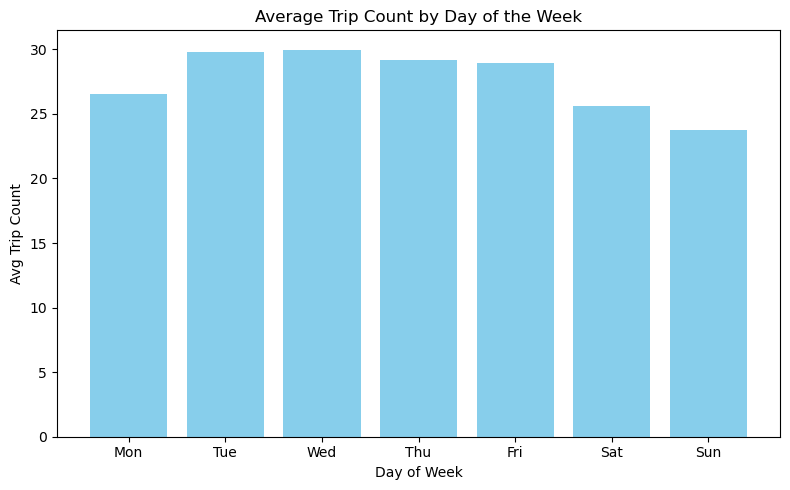

In [17]:
# Assume 'daily_counts_w' is your DataFrame with 'date' and 'trip_count' columns
daily_counts_w['date'] = pd.to_datetime(daily_counts_w['date'])
daily_counts_w['dayofweek'] = daily_counts_w['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Compute average trips per day of week
avg_by_day = (
    daily_counts_w.groupby('dayofweek')['trip_count']
    .mean()
    .reset_index()
)

# Optional: map day numbers to names for readability
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_day['day_name'] = avg_by_day['dayofweek'].map(dict(zip(range(7), day_labels)))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(avg_by_day['day_name'], avg_by_day['trip_count'], color='skyblue')
plt.title('Average Trip Count by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Avg Trip Count')
plt.tight_layout()
plt.show()

To investigate behavioral trends in Bluebikes usage, we plotted the average daily trip count by day of the week. Data shows:

- Higher usage on weekdays
- Lower usage on weekends, with Sunday having the lowest average trip count.

This suggests that Bluebikes are primarily used for commuting purposes, particularly on workdays and university days. Many stations are concentrated in business districts and universities. This makes sense because Boston is a very walkable city.

We will create two features later on:
- `dayofweek` — to capture cyclical weekday trends
- `is_weekend` — to indicate weekends vs. weekdays